In [1]:
#Goal: create word vectors from 800 contracts in the dod-db. 
from __future__ import absolute_import, division, print_function
import codecs
import glob
#concurrency
import multiprocessing
import os
import pprint
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import pandas as pd
import seaborn as sns
import re

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/Mehrotra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Mehrotra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#step 1 process data

#initialize rawunicode , we'll add all text to this one bigass file in memory
data_raw = u""
#for each book, read it, open it un utf 8 format, 
#add it to the raw corpus
with codecs.open("data/semantics.csv", "r", "utf-8") as data:
    data_raw += data.read()
print(data_raw)

for_what
"Surveillance Radar Program operations and maintenance follow-on sustainment package that includes contractor logistics support (sustainment); engineering services and technical updates to address equipment obsolescence; transportation and material costs associated with contractor repair and return services; spare and repair parts; support and test equipment; publications and technical documentation personnel training and training equipment; government and contractor engineering; technical and logistics support services; and other related elements of logistical and program support"
"Small Diameter Bomb (SDB) Increment 1 Lots 12-14 production"
"support of the Korea Peace Krypton prime mission equipment, RC-800 aircraft and technical manuals"
"The contract modification is to establish negotiated prices for option II for the contractor to provide sustaining engineering services for the KC-135 weapon system, including airframe and airframe components, mechanical and electrical sys

In [4]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')


In [5]:
raw_sentences = tokenizer.tokenize(data_raw)

In [6]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [7]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [8]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

The ESSM program is an international cooperative effort to design, develop, test, and procure ESSM missiles.
[u'The', u'ESSM', u'program', u'is', u'an', u'international', u'cooperative', u'effort', u'to', u'design', u'develop', u'test', u'and', u'procure', u'ESSM', u'missiles']


In [9]:
token_count = sum([len(sentence) for sentence in sentences])
print("The data contains {0:,} tokens".format(token_count))

The data contains 16,801 tokens


In [10]:
#step 2 build our model, another one is Glove
#define hyperparameters

# Dimensionality of the resulting word vectors.
#more dimensions mean more traiig them, but more generalized
num_features = 300

#
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#rate 0 and 1e-5 
#how often to use
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
seed = 1

In [11]:
contracts2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [12]:
contracts2vec.build_vocab(sentences)


In [13]:
contracts2vec.train(sentences,total_examples=contracts2vec.corpus_count, epochs=800)

(8122774, 13440800)

In [14]:
if not os.path.exists("trained"):
    os.makedirs("trained")


In [15]:
contracts2vec.save(os.path.join("trained", "contracts2vec.w2v"))


In [16]:
contracts2vec = w2v.Word2Vec.load(os.path.join("trained", "contracts2vec.w2v"))


In [17]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [18]:
all_word_vectors_matrix = contracts2vec.wv.vectors

In [19]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [20]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[contracts2vec.wv.vocab[word].index])
            for word in contracts2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [21]:
sns.set_context("poster")


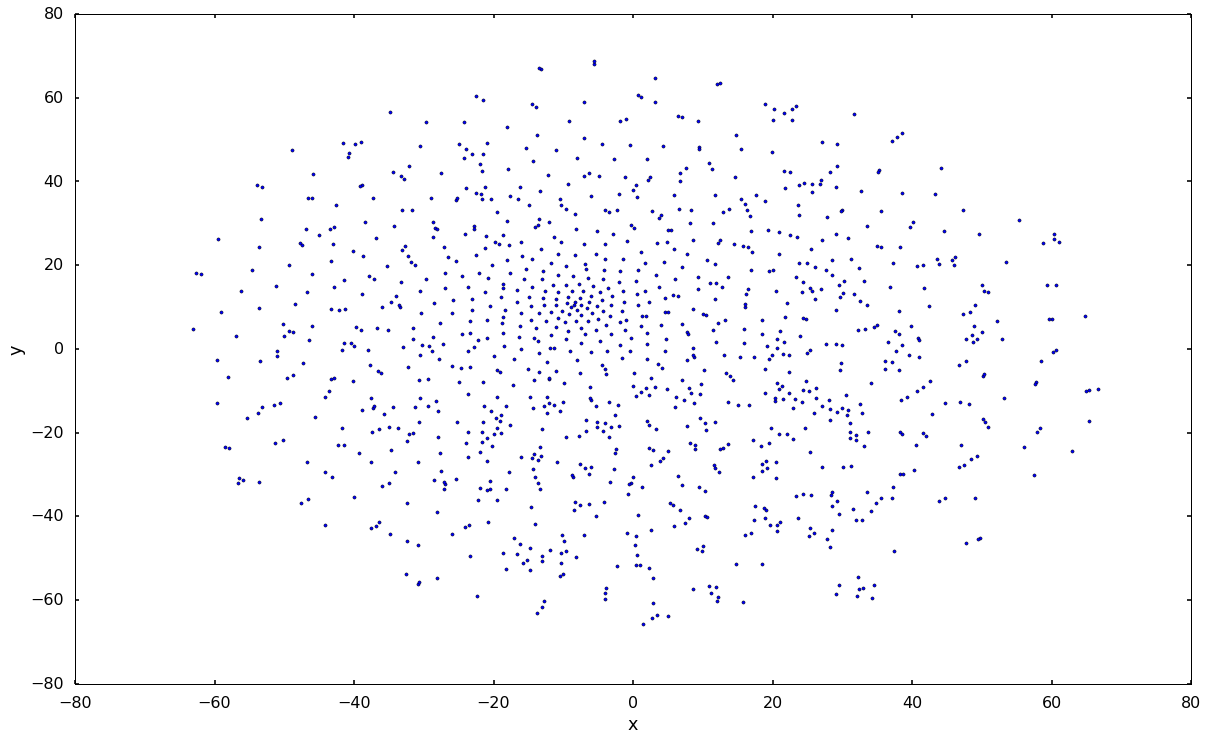

In [22]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))


In [22]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

In [23]:
contracts2vec.most_similar("missile")


/Users/Mehrotra/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'guided', 0.46515610814094543),
 (u'round', 0.43018075823783875),
 (u'launched', 0.3931579887866974),
 (u'AIM', 0.3879282474517822),
 (u'tube', 0.37522533535957336),
 (u'defense', 0.3728128671646118),
 (u'segment', 0.3681540787220001),
 (u'optically', 0.36598578095436096),
 (u'missiles', 0.35477522015571594),
 (u'Bomb', 0.34179383516311646)]